In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA

In [2]:
def timestamp2date(timestamp):
    timeArray = time.localtime(timestamp)
    formatted_time = time.strftime("%Y-%m-%d %H:%M:%S", timeArray)
    return formatted_time

In [3]:
# read data
df = pd.read_csv(r"D:\Research\UBI车险\data\486_wuhan_test - LT.csv")
df[3716:3725]

,t,VehSpdLgtA
3716,1664774464,1.466075
3717,1664774465,2.290549
3718,1664774466,3.062756
3719,1664774467,3.619785
3720,1664774468,4.029551
3721,1664774469,4.158022
3722,1664774470,4.267677
3723,1664774471,4.304910
3724,1664774472,4.054787


In [4]:
# convert timestamp
df["date"] = df["t"].apply(timestamp2date)
df = df[["t","date","VehSpdLgtA"]]
df[3716:3725]

,t,date,VehSpdLgtA
3716,1664774464,2022-10-03 13:21:04,1.466075
3717,1664774465,2022-10-03 13:21:05,2.290549
3718,1664774466,2022-10-03 13:21:06,3.062756
3719,1664774467,2022-10-03 13:21:07,3.619785
3720,1664774468,2022-10-03 13:21:08,4.029551
3721,1664774469,2022-10-03 13:21:09,4.158022
3722,1664774470,2022-10-03 13:21:10,4.267677
3723,1664774471,2022-10-03 13:21:11,4.304910
3724,1664774472,2022-10-03 13:21:12,4.054787


In [5]:
# drop reduplicative records
df = df.drop_duplicates(subset = ["t"]).sort_values(by = ["t"]).reset_index(drop = True)

In [6]:
# partition journey
df["dt"] = df["t"].diff()
df["stop"] = df["dt"] != 1
df["journeyID"] = df["stop"].cumsum()
df.loc[df["dt"] != 1].head(5)

,t,date,VehSpdLgtA,dt,stop,journeyID
0,1664771299,2022-10-03 12:28:19,0.0000,NaN,True,1
3432,1664774743,2022-10-03 13:25:43,8.3963,13.0,True,2
18852,1664790168,2022-10-03 17:42:48,0.0000,6.0,True,3
18867,1664790201,2022-10-03 17:43:21,0.0000,19.0,True,4
18872,1664790352,2022-10-03 17:45:52,0.0000,147.0,True,5


In [7]:
# interpolate speed
df["VehSpdLgtA"] = df.groupby("journeyID")["VehSpdLgtA"].apply(lambda v: v.interpolate(limit_direction = "both"))
df["VehSpdLgtA"] = df["VehSpdLgtA"].fillna(0)
df.isnull().sum()

t             0
date          0
VehSpdLgtA    0
dt            1
stop          0
journeyID     0
dtype: int64

In [8]:
# calculate tangential acceleration
def get_tgAcceleration(df):
    dVehSpdLgtA = df["VehSpdLgtA"].diff() / 3.6
    dt = df["t"].diff()
    df["tg_acceleration"] = dVehSpdLgtA / dt
    return df
df = df.groupby("journeyID").apply(get_tgAcceleration)

In [9]:
# omit the first row of every journey (beacause of NaN of tg_acceleration)
df = df.groupby("journeyID").apply(lambda x:x.iloc[1:]).reset_index(drop = True)

In [10]:
# omit meaningless journeies(v == 0 or cumsum(t) less than 3min)
df["is_meaningless"] = df.groupby("journeyID")["VehSpdLgtA"].transform(lambda v: True if (np.sum(v) == 0 or len(v) < 3 * 60) else False)
df = df[~df["is_meaningless"]].reset_index(drop = True)
df = df[["t","date","journeyID","VehSpdLgtA","tg_acceleration"]]
df[3432 - 5:3432 + 5]

,t,date,journeyID,VehSpdLgtA,tg_acceleration
3427,1664774727,2022-10-03 13:25:27,1,1.437246,0.075509
3428,1664774728,2022-10-03 13:25:28,1,2.372126,0.259689
3429,1664774729,2022-10-03 13:25:29,1,4.000397,0.452297
3430,1664774730,2022-10-03 13:25:30,1,5.984167,0.551047
3431,1664774744,2022-10-03 13:25:44,2,9.990342,0.442789
3432,1664774745,2022-10-03 13:25:45,2,11.545004,0.431851
3433,1664774746,2022-10-03 13:25:46,2,12.564903,0.283305
3434,1664774747,2022-10-03 13:25:47,2,13.221111,0.182280
3435,1664774748,2022-10-03 13:25:48,2,13.780416,0.155363
3436,1664774749,2022-10-03 13:25:49,2,14.191997,0.114328


<AxesSubplot:>

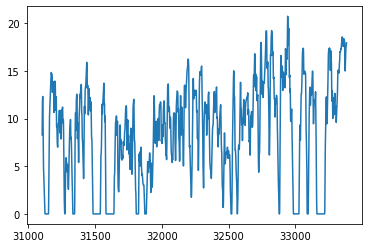

In [25]:
# speed visualize
df_vis = df[df["journeyID"] == 26]
df_vis["VehSpdLgtA"].plot()

Text(0, 0.5, 'tg_acceleration')

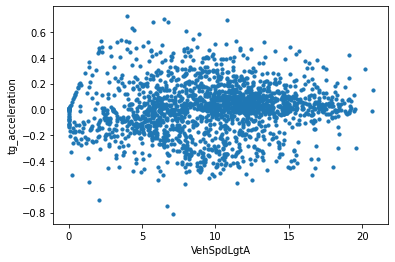

In [26]:
# speed-acceleration visualize
ax_1 = plt.scatter(df_vis["VehSpdLgtA"],df_vis["tg_acceleration"],s = 10)
plt.xlabel("VehSpdLgtA")
plt.ylabel("tg_acceleration")

In [27]:
# kernel density visualize
def kde2D(x, y, bandwidth, xbins=10j, ybins=10j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 10x10)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    zz = np.reshape(z, xx.shape)
    z_norm = z / z.sum()
    z_norm= z_norm.ravel()
    return xx,yy,zz,z_norm

C:\Users\lenovo\AppData\Local\Temp/ipykernel_16408/1265726103.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz)


Text(0, 0.5, 'tg_acceleration')

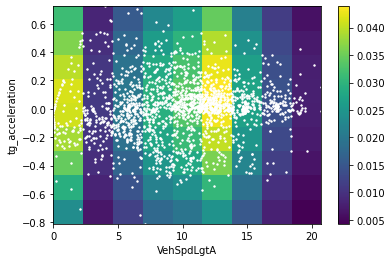

In [28]:
x,y = df_vis["VehSpdLgtA"],df_vis["tg_acceleration"]
xx,yy,zz,z_norm = kde2D(x,y,bandwidth = 0.75)
plt.pcolormesh(xx, yy, zz)
plt.colorbar()
plt.scatter(x, y, s=2, facecolor='white')
plt.xlabel("VehSpdLgtA")
plt.ylabel("tg_acceleration")

In [29]:
# kernel density analysis
results = df.groupby("journeyID").apply(lambda x:kde2D(x["VehSpdLgtA"],x["tg_acceleration"],bandwidth = 0.75))
results = [{"journeyID":index, "z_norm":results[index][3]} for index in results.index]
z_norms = pd.DataFrame(results)
z_norms = pd.DataFrame(z_norms["z_norm"].to_list(),columns = ["z_norm" + str(i) for i in range(1,101)])
mean = z_norms.mean(axis = 0)
std = z_norms.std(axis = 0)
z_norms = (z_norms - mean)/std
z_norms 

,z_norm1,z_norm2,z_norm3,z_norm4,z_norm5,z_norm6,z_norm7,z_norm8,z_norm9,z_norm10,...,z_norm91,z_norm92,z_norm93,z_norm94,z_norm95,z_norm96,z_norm97,z_norm98,z_norm99,z_norm100
0,2.422611,2.302941,2.142370,1.964457,1.813620,1.742592,1.788735,1.954122,2.188247,2.396581,...,-0.410349,-0.415507,-0.422281,-0.430261,-0.438590,-0.446283,-0.452455,-0.456416,-0.457539,-0.454858
1,-0.520177,-0.377138,-0.181259,0.038249,0.237799,0.380135,0.445467,0.422810,0.305952,0.113388,...,-0.485311,-0.457487,-0.429723,-0.405032,-0.386448,-0.376895,-0.378670,-0.392744,-0.417960,-0.450171
2,0.380251,0.533540,0.652611,0.723363,0.746868,0.739682,0.719071,0.685961,0.621389,0.505804,...,-0.533797,-0.530630,-0.530551,-0.533746,-0.539672,-0.547515,-0.556459,-0.565716,-0.574220,-0.579920
3,-0.391072,-0.409196,-0.436802,-0.461853,-0.470638,-0.455915,-0.418034,-0.360471,-0.290419,-0.224867,...,-0.400665,-0.373476,-0.350095,-0.331322,-0.317425,-0.308598,-0.305228,-0.307966,-0.317480,-0.333728
4,-0.664420,-0.789677,-0.926428,-1.047002,-1.125578,-1.153629,-1.136743,-1.077237,-0.968973,-0.818306,...,-0.477166,-0.467894,-0.461994,-0.459507,-0.459848,-0.462279,-0.466201,-0.471240,-0.477021,-0.482545
5,0.041889,-0.063375,-0.203037,-0.350699,-0.474239,-0.552167,-0.579073,-0.556205,-0.486577,-0.386148,...,2.264466,2.354737,2.408957,2.437678,2.446545,2.437213,2.407598,2.351323,2.256647,2.106058
6,0.165199,0.416173,0.610278,0.683257,0.606445,0.401387,0.115126,-0.205210,-0.506705,-0.726411,...,-0.519229,-0.509950,-0.504700,-0.504727,-0.510278,-0.520848,-0.535333,-0.552103,-0.568850,-0.582123
7,-0.895697,-0.805646,-0.589359,-0.266975,0.082919,0.359925,0.489990,0.439090,0.217686,-0.097683,...,-0.545887,-0.539209,-0.532881,-0.527731,-0.524718,-0.525139,-0.530242,-0.540470,-0.554568,-0.568822
8,-0.538584,-0.807622,-1.068374,-1.282797,-1.417195,-1.462011,-1.424540,-1.302860,-1.080599,-0.762358,...,1.107939,0.939415,0.823268,0.754650,0.730436,0.750342,0.816990,0.935333,1.110992,1.346110


In [30]:
# principal components analysis
pca = PCA(n_components = 5)
pca.fit(z_norms)
print("explained_variance_ratio_: ",pca.explained_variance_ratio_)
print("cummulative explained_variance_ratio_: ",np.cumsum(pca.explained_variance_ratio_))
pca_score = np.dot(z_norms,pca.components_.T)
pca_score

explained_variance_ratio_:  [0.36169439 0.21297538 0.18077511 0.10790521 0.07918913]
cummulative explained_variance_ratio_:  [0.36169439 0.57466978 0.75544489 0.8633501  0.94253923]


array([[11.96681423,  3.61289037,  0.26927406, -2.38708862,  2.62858988],
       [-0.11609337,  0.06376755, -6.1763313 ,  0.92698316,  0.65898178],
       [ 5.31322784, -5.23979696,  2.08223788, -1.34191309, -3.38786036],
       [-3.52234139,  0.6970041 , -1.58374937, -0.4737477 ,  4.67996045],
       [-6.8057986 , -3.09198362, -4.90418096, -1.25377973, -0.62565593],
       [-4.06831019, 10.28540795,  1.81417559,  0.88647259, -3.06758193],
       [ 1.17774194, -1.43242058, -1.63717063, -2.05527688, -3.07597156],
       [ 2.11764467, -2.45965204,  2.05396082,  8.08959264,  0.39914309],
       [-6.06288513, -2.43521679,  8.08178392, -2.39124237,  1.79039458]])